# CELL 1: Install Required Packages

Triple SMA Trading Strategy with QuantStats for Google Colab
============================================================

This notebook implements the Triple SMA (20/50/200) trading strategy
with comprehensive performance analytics using QuantStats.

Run each cell sequentially for best results.

In [47]:
print("📦 Installing required packages...")

# Core packages
!pip install pandas>=1.3.0 numpy>=1.21.0 matplotlib>=3.4.0

# IBKR API
!pip install --upgrade pip
!pip install ibapi>=9.81.1

# Performance analytics
!pip install quantstats>=0.0.59

# Additional packages
!pip install yfinance>=0.1.87 requests

print("✅ All packages installed successfully!")


📦 Installing required packages...
✅ All packages installed successfully!


# CELL 2: Import Libraries and Setup

In [48]:
# Verify installation and import libraries
try:
    import datetime
    import time
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from ibapi.client import EClient
    from ibapi.wrapper import EWrapper
    from ibapi.contract import Contract
    from ibapi.order import Order
    import threading
    import functools
    import quantstats as qs
    import requests
    import json
    import socket

    print("✅ All required packages imported successfully!")

except ImportError as e:
    print(f"❌ Package import failed: {e}")
    print("Please run the installation cell above and try again.")

# Enable QuantStats Jupyter integration
qs.extend_pandas()

# Set matplotlib style for better visualizations - Colab compatible
plt.style.use('default')
plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Fix font warnings in Colab - Complete suppression
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'sans-serif']

# Completely suppress all matplotlib font warnings
import warnings
import logging
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', message='.*font.*')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

print("🎨 Matplotlib styling configured (Colab compatible)")
print("📊 QuantStats integration enabled")

✅ All required packages imported successfully!
🎨 Matplotlib styling configured (Colab compatible)
📊 QuantStats integration enabled


# CELL 3: IBKR API Wrapper Class

In [49]:
class IBapi(EWrapper, EClient):
    def __init__(self):
        EClient.__init__(self, self)
        self.data = []  # Initialize variable to store candle data
        self.positions = {}  # Dictionary to store current positions
        self.data_received = False

    def historicalData(self, reqId, bar):
        # Called when historical data is received
        self.data.append([bar.date, bar.open, bar.high, bar.low, bar.close, bar.volume])

    def historicalDataEnd(self, reqId, start, end):
        # Called when all historical data has been received
        print(f"📈 Historical data received from {start} to {end}")
        self.data_received = True

    def position(self, account, contract, position, avgCost):
        # Called when position information is received
        super().position(account, contract, position, avgCost)
        key = contract.symbol
        self.positions[key] = position
        print(f"💼 Current position for {key}: {position} shares at avg cost of {avgCost}")

    def nextValidId(self, orderId):
        # Called when connection is established and next valid order ID is received
        super().nextValidId(orderId)
        self.nextOrderId = orderId
        print(f"🔗 Connected to TWS. Next valid order ID: {orderId}")

    def error(self, reqId, errorCode, errorString):
        # Called when an error occurs
        if errorCode != 2104 and errorCode != 2106:  # Ignore common info messages
            print(f"⚠️ Error {errorCode}: {errorString}")

    def orderStatus(self, orderId, status, filled, remaining, avgFillPrice,
                   permId, parentId, lastFillPrice, clientId, whyHeld, mktCapPrice):
        # Called when order status changes
        print(f"📋 Order {orderId} status: {status}, filled: {filled}, remaining: {remaining}, price: {avgFillPrice}")

print("✅ IBKR API wrapper class defined")

✅ IBKR API wrapper class defined


# CELL 4: Utility Functions

In [50]:
def create_contract(symbol, secType='STK', exchange='SMART', currency='USD'):
    """Create a contract object for a specific security"""
    contract = Contract()
    contract.symbol = symbol
    contract.secType = secType
    contract.exchange = exchange
    contract.currency = currency
    return contract

def create_order(action, quantity, order_type='MKT'):
    """Create an order object"""
    order = Order()
    order.action = action
    order.totalQuantity = quantity
    order.orderType = order_type
    return order

print("🔧 Utility functions defined")

🔧 Utility functions defined


# CELL 5: Triple SMA Strategy Calculation (Optimized)

In [51]:
@functools.lru_cache(maxsize=32)
def calculate_triple_sma_optimized(data_tuple, sma20_period=20, sma50_period=50, sma200_period=200):
    """
    Calculate Triple SMA and generate signals based on the strategy using optimized pandas

    Note: data_tuple is a tuple representation of the data for caching purposes
    """
    # Convert tuple back to list for processing
    data = list(data_tuple)

    # Pre-allocate DataFrame with known size for better performance
    df = pd.DataFrame(data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])

    # Convert date strings to datetime objects if needed
    if isinstance(df['date'].iloc[0], str):
        df['date'] = pd.to_datetime(df['date'], format='%Y%m%d %H:%M:%S')

    # Set date as index for QuantStats compatibility
    df = df.set_index('date')

    # Calculate SMAs using pandas rolling - vectorized operation
    df['sma20'] = df['close'].rolling(window=sma20_period).mean()
    df['sma50'] = df['close'].rolling(window=sma50_period).mean()
    df['sma200'] = df['close'].rolling(window=sma200_period).mean()

    # Generate signals using vectorized operations instead of loops
    # Create boolean masks for conditions
    uptrend = (df['close'] > df['sma20']) & (df['sma20'] > df['sma50']) & (df['sma50'] > df['sma200'])
    downtrend = (df['close'] < df['sma20']) & (df['sma20'] < df['sma50']) & (df['sma50'] < df['sma200'])

    # Initialize signal column with zeros
    df['signal'] = 0

    # Apply conditions using vectorized operations
    df.loc[uptrend, 'signal'] = 1
    df.loc[downtrend, 'signal'] = -1

    # Calculate position changes using diff (vectorized)
    df['position'] = df['signal'].diff()

    # Calculate returns for QuantStats
    df['returns'] = df['close'].pct_change()

    # Calculate strategy returns (position at previous day's close * today's return)
    df['strategy_returns'] = df['signal'].shift(1) * df['returns']

    # Fill NaN values with zeros
    df['strategy_returns'] = df['strategy_returns'].fillna(0)

    return df

print("🧮 Triple SMA calculation function defined (optimized)")

🧮 Triple SMA calculation function defined (optimized)


# CELL 6: Visualization Functions

In [52]:
def visualize_triple_sma_strategy_optimized(df, symbol):
    """
    Visualize the Triple SMA strategy results with optimized matplotlib
    """
    # Create a copy of df with date as a column for plotting
    plot_df = df.reset_index()

    # Create figure with specific size for better quality
    fig, ax = plt.subplots(figsize=(15, 8), dpi=100)

    # Format dates for better display
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.xticks(rotation=45)

    # Plot price and SMAs with optimized Line2D objects for large datasets
    ax.plot(plot_df['date'], plot_df['close'], label='Close Price', alpha=0.8, linewidth=1.5, color='black')
    ax.plot(plot_df['date'], plot_df['sma20'], label='SMA 20', color='#3177e0', linewidth=2)
    ax.plot(plot_df['date'], plot_df['sma50'], label='SMA 50', color='#ff9800', linewidth=2)
    ax.plot(plot_df['date'], plot_df['sma200'], label='SMA 200', color='#f44336', linewidth=2)

    # Plot buy/sell signals
    buy_signals = plot_df[plot_df['position'] > 0]
    sell_signals = plot_df[plot_df['position'] < 0]

    # Use scatter for signals
    if not buy_signals.empty:
        ax.scatter(buy_signals['date'], buy_signals['close'], marker='^', color='green', s=100, label='Buy Signal', zorder=5)
    if not sell_signals.empty:
        ax.scatter(sell_signals['date'], sell_signals['close'], marker='v', color='red', s=100, label='Sell Signal', zorder=5)

    # Add grid and labels with improved styling
    ax.set_title(f'📊 Triple SMA Strategy for {symbol}', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price ($)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)

    # Adjust layout to prevent cut-off labels
    plt.tight_layout()

    # Show plot
    plt.show()

    return fig

print("📈 Visualization functions defined")

📈 Visualization functions defined


 # CELL 7: QuantStats Analytics Functions

In [54]:
def generate_quantstats_reports(df, symbol, benchmark_ticker='SPY'):
    """
    Generate comprehensive performance reports using QuantStats
    """
    print("\n🔍 === Generating QuantStats Reports ===")

    # Extract strategy returns for QuantStats
    strategy_returns = df['strategy_returns'].dropna()

    if strategy_returns.empty or strategy_returns.sum() == 0:
        print("⚠️ No strategy returns to analyze. Strategy may not have generated any trades.")
        return strategy_returns

    try:
        # Basic metrics
        print("\n📊 Basic Performance Metrics:")
        print(f"📈 CAGR: {qs.stats.cagr(strategy_returns):.2%}")
        print(f"⚡ Sharpe Ratio: {qs.stats.sharpe(strategy_returns):.2f}")
        print(f"📉 Max Drawdown: {qs.stats.max_drawdown(strategy_returns):.2%}")
        print(f"🎯 Win Rate: {qs.stats.win_rate(strategy_returns):.2%}")
        print(f"📊 Volatility (Ann.): {qs.stats.volatility(strategy_returns, annualize=True):.2%}")

        # Plot returns
        print("\n📊 Plotting Cumulative Returns...")
        try:
            qs.plots.returns(strategy_returns, benchmark=None, figsize=(12, 6))
            plt.title(f'Cumulative Returns - {symbol}')
            plt.show()
        except Exception as e:
            print(f"⚠️ Could not plot returns comparison: {e}")

        # Plot drawdowns
        print("\n📉 Plotting Drawdowns...")
        qs.plots.drawdown(strategy_returns, figsize=(12, 4))
        plt.title(f'Drawdowns - {symbol}')
        plt.show()

        # Plot monthly returns heatmap
        print("\n🔥 Plotting Monthly Returns Heatmap...")
        try:
            qs.plots.monthly_heatmap(strategy_returns, figsize=(10, 6))
            plt.title(f'Monthly Returns Heatmap - {symbol}')
            plt.show()
        except Exception as e:
            print(f"⚠️ Could not plot monthly heatmap: {e}")

        # Generate metrics table
        print("\n📋 Detailed Metrics:")
        metrics = qs.reports.metrics(strategy_returns, mode='basic', display=False)
        print(metrics)

    except Exception as e:
        print(f"❌ Error generating QuantStats reports: {e}")
        print("📊 Generating basic statistics instead...")

        print(f"Total Return: {(strategy_returns + 1).prod() - 1:.2%}")
        print(f"Mean Daily Return: {strategy_returns.mean():.4%}")
        print(f"Std Daily Return: {strategy_returns.std():.4%}")

    return strategy_returns

print("📊 QuantStats analytics functions defined")

📊 QuantStats analytics functions defined


# CELL 8: Sample Data Generation Function

In [55]:
def run_with_sample_data(symbol="KO", benchmark_ticker=None):
    """Run the strategy with sample data and generate QuantStats reports"""
    print("\n🎲 Using sample data for demonstration...")

    # Generate sample data
    import numpy as np

    # Create dates
    start_date = pd.Timestamp('2022-01-01')
    dates = [start_date + pd.Timedelta(days=i) for i in range(500)]

    # Generate price data with some trend and noise
    np.random.seed(42)  # For reproducibility
    price = 100
    prices = [price]
    for _ in range(499):
        change = np.random.normal(0.0005, 0.02)  # Small positive drift with volatility
        price = price * (1 + change)
        prices.append(max(price, 10))  # Prevent negative prices

    # Create sample data in the format expected by the strategy
    sample_data = []
    for i, date in enumerate(dates):
        high = prices[i] * np.random.uniform(1.0, 1.02)
        low = prices[i] * np.random.uniform(0.98, 1.0)
        open_price = prices[i] * np.random.uniform(0.99, 1.01)

        sample_data.append([
            date.strftime('%Y%m%d %H:%M:%S'),
            open_price,    # Open
            high,          # High
            low,           # Low
            prices[i],     # Close
            int(np.random.normal(1000000, 200000))  # Volume
        ])

    # Convert to tuple for caching
    sample_data_tuple = tuple(map(tuple, sample_data))

    # Calculate Triple SMA and generate signals
    df = calculate_triple_sma_optimized(sample_data_tuple)

    # Visualize the strategy
    visualize_triple_sma_strategy_optimized(df, symbol)

    # Generate QuantStats reports
    generate_quantstats_reports(df, symbol, benchmark_ticker)

    return df

print("🎲 Sample data generation function defined")

🎲 Sample data generation function defined


# CELL 9: IBKR Connection and Strategy Testing Functions

In [56]:
def check_ngrok_status():
    """Check if ngrok is running and get tunnel information"""
    try:
        # ngrok exposes a local API on port 4040
        response = requests.get('http://localhost:4040/api/tunnels', timeout=5)
        if response.status_code == 200:
            tunnels = response.json()['tunnels']
            tcp_tunnels = [t for t in tunnels if t['proto'] == 'tcp']
            if tcp_tunnels:
                tunnel = tcp_tunnels[0]  # Get first TCP tunnel
                public_url = tunnel['public_url']
                host = public_url.split('://')[1].split(':')[0]
                port = int(public_url.split(':')[-1])
                return True, host, port, tunnel['config']['addr']
        return False, None, None, None
    except:
        return False, None, None, None

def setup_connection():
    """Enhanced connection setup with ngrok auto-detection"""
    print("\n🔍 Checking connection options...")

    # Check if we're in Colab
    try:
        import google.colab
        in_colab = True
        print("📱 Running in Google Colab")
    except ImportError:
        in_colab = False
        print("💻 Running locally")

    if in_colab:
        print("\n⚠️  Google Colab requires tunneling to connect to local TWS")

        # Check if ngrok is running
        ngrok_running, host, port, local_addr = check_ngrok_status()

        if ngrok_running:
            print(f"✅ ngrok detected!")
            print(f"🌐 Public URL: {host}:{port}")
            print(f"🔗 Local target: {local_addr}")

            use_detected = input(f"🎯 Use detected ngrok tunnel {host}:{port}? (y/n): ").lower().strip()
            if use_detected == 'y':
                return host, port

        print("\n📋 ngrok Setup Instructions:")
        print("1. Download ngrok: https://ngrok.com/download")
        print("2. Sign up: https://dashboard.ngrok.com/signup")
        print("3. Get authtoken: https://dashboard.ngrok.com/get-started/your-authtoken")
        print("4. In your local terminal:")
        print("   ngrok config add-authtoken YOUR_TOKEN")
        print("   ngrok tcp 7497")
        print("5. Copy the forwarding URL (like 0.tcp.ngrok.io:12345)")

        print("\n🔧 Manual ngrok entry:")
        host = input("🔗 Enter ngrok host (e.g., 0.tcp.ngrok.io): ").strip()
        if not host:
            print("❌ Host cannot be empty for Colab connection")
            return None, None

        try:
            port = int(input("🚪 Enter ngrok port: ").strip())
        except ValueError:
            print("❌ Invalid port number")
            return None, None

        return host, port

    else:
        # Local connection
        print("✅ Local connection available")
        host = input("🔗 Enter TWS host (default: 127.0.0.1): ").strip() or "127.0.0.1"
        try:
            port = int(input("🚪 Enter TWS port (default: 7497): ").strip() or "7497")
        except ValueError:
            print("❌ Invalid port number")
            return None, None

        return host, port

def test_connection(host, port):
    """Test connection with better error reporting"""
    print(f"\n🔌 Testing connection to {host}:{port}...")

    try:
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.settimeout(5)
        result = sock.connect_ex((host, port))
        sock.close()

        if result == 0:
            print(f"✅ Connection successful to {host}:{port}")
            return True
        else:
            print(f"❌ Cannot connect to {host}:{port}")
            print("🔍 Troubleshooting:")
            print("   • Ensure TWS/Gateway is running")
            print("   • Check API settings are enabled")
            print("   • Verify port number (7497 for TWS Paper, 4002 for Gateway Paper)")
            if "ngrok" in host:
                print("   • Verify ngrok tunnel is active")
                print("   • Check ngrok authtoken is configured")
            return False
    except Exception as e:
        print(f"❌ Connection test failed: {e}")
        return False

print("🔧 Connection helper functions defined")

🔧 Connection helper functions defined


# CELL 10: Main Execution Interface

In [57]:
def test_triple_sma_strategy(host='127.0.0.1', port=7497, symbol='KO', benchmark_ticker='SPY'):
    """Test the Triple SMA strategy for a specific symbol using optimized pandas and QuantStats"""
    print(f"\n🔌 Attempting to connect to TWS at {host}:{port}")

    # Connect to TWS
    app = IBapi()
    app.connect(host, port, 0)  # 7497 for TWS Paper Trading

    # Start the socket in a separate thread
    api_thread = threading.Thread(target=app.run, daemon=True)
    api_thread.start()

    # Wait for connection to establish
    time.sleep(3)

    if not app.isConnected():
        print("❌ Failed to connect to TWS. Please check:")
        print("   • TWS/IB Gateway is running")
        print("   • API connections are enabled")
        print("   • Host and port are correct")
        print("   • ngrok tunnel is active (if using)")
        return None

    # Create contract for the symbol
    contract = create_contract(symbol)

    # Request historical data
    app.data = []  # Reset data
    app.data_received = False

    print(f"📡 Requesting 2 years of daily data for {symbol}...")

    # Request 2 years of daily data to have enough for SMA 200
    app.reqHistoricalData(
        reqId=1,
        contract=contract,
        endDateTime='',  # Empty string means "now"
        durationStr='2 Y',  # Duration of data (2 years)
        barSizeSetting='1 day',  # Bar size (1 day)
        whatToShow='MIDPOINT',  # Type of data
        useRTH=1,  # Regular Trading Hours only
        formatDate=1,  # Date format (1 = yyyyMMdd HH:mm:ss)
        keepUpToDate=False,  # Don't keep updating
        chartOptions=[]  # No chart options
    )

    # Wait for data to be received
    timeout = 20  # seconds
    start_time = time.time()
    while not app.data_received and time.time() - start_time < timeout:
        time.sleep(0.5)

    # Disconnect
    app.disconnect()

    # Process data and apply strategy
    if len(app.data) > 0:
        print(f"✅ Received {len(app.data)} bars of historical data for {symbol}")

        # Start timing for performance measurement
        start_time = time.time()

        # Convert data to tuple for caching
        data_tuple = tuple(map(tuple, app.data))

        # Calculate Triple SMA and generate signals using optimized pandas
        df = calculate_triple_sma_optimized(data_tuple)

        # End timing
        execution_time = time.time() - start_time
        print(f"⚡ Strategy calculation took {execution_time:.4f} seconds")

        # Visualize the strategy
        visualize_triple_sma_strategy_optimized(df, symbol)

        # Calculate performance metrics
        if len(df[df['position'] != 0]) > 0:
            # Count buy and sell signals
            buy_signals = len(df[df['position'] > 0])
            sell_signals = len(df[df['position'] < 0])

            print(f"\n📊 Strategy Performance Summary for {symbol}:")
            print(f"🟢 Total Buy Signals: {buy_signals}")
            print(f"🔴 Total Sell Signals: {sell_signals}")

            # Current signal
            current_signal = df['signal'].iloc[-1]
            if current_signal == 1:
                print(f"🚀 Current Signal: BUY/HOLD (Strong Uptrend)")
            elif current_signal == -1:
                print(f"🔻 Current Signal: SELL/SHORT (Strong Downtrend)")
            else:
                print(f"➡️ Current Signal: NEUTRAL (No Clear Trend)")

            # Current SMA values
            print(f"\n📈 Current SMA Values:")
            print(f"   SMA 20: ${df['sma20'].iloc[-1]:.2f}")
            print(f"   SMA 50: ${df['sma50'].iloc[-1]:.2f}")
            print(f"   SMA 200: ${df['sma200'].iloc[-1]:.2f}")
            print(f"   Current Price: ${df['close'].iloc[-1]:.2f}")

            # Generate QuantStats reports
            generate_quantstats_reports(df, symbol, benchmark_ticker)

        else:
            print("⚠️ No trading signals generated for the given data.")

        return df
    else:
        print(f"❌ No data received for {symbol}")
        return None

def execute_trade(host, port, symbol, action, quantity):
    """Execute a trade for a specific symbol"""
    print(f"\n🔌 Connecting to TWS for trade execution...")

    # Connect to TWS
    app = IBapi()
    app.connect(host, port, 0)  # Connect to TWS

    # Start the socket in a separate thread
    api_thread = threading.Thread(target=app.run, daemon=True)
    api_thread.start()

    # Wait for connection to establish
    time.sleep(3)

    if not app.isConnected():
        print("❌ Failed to connect to TWS for trade execution.")
        return False

    # Create contract for the symbol
    contract = create_contract(symbol)

    # Create order
    order = create_order(action, quantity)

    # Place order
    app.placeOrder(app.nextOrderId, contract, order)
    print(f"📋 Placed {action} order for {quantity} shares of {symbol}")

    # Wait for order to be processed
    time.sleep(5)

    # Disconnect
    app.disconnect()

    return True

print("🔗 IBKR trading functions defined")

🔗 IBKR trading functions defined


# CELL 11: Main Execution Interface

In [58]:
def run_triple_sma_system():
    """Main execution function with user interface"""
    print("\n" + "="*70)
    print("🚀 TRIPLE SMA TRADING STRATEGY WITH QUANTSTATS")
    print("="*70)
    print("📊 This system implements a trading strategy based on 20, 50, and 200-day SMAs")
    print("📈 Enhanced with QuantStats performance analytics")
    print("\n📋 Available Options:")
    print("1️⃣  Test strategy with IBKR data (requires TWS/Gateway)")
    print("2️⃣  Execute trade based on current signal")
    print("3️⃣  Demo with sample data (no IBKR connection needed)")
    print("4️⃣  View system information")

    choice = input("\n🎯 Enter your choice (1-4): ").strip()

    if choice in ["1", "2"]:
        # Connection required
        host, port = setup_connection()
        if host is None or port is None:
            print("❌ Connection setup failed")
            return

        # Test connection first
        if not test_connection(host, port):
            print("❌ Cannot proceed without valid connection")
            return

        if choice == "1":
            # Test strategy
            symbol = input("📈 Enter symbol (default: AAPL): ").strip().upper() or "AAPL"
            benchmark = input("📊 Enter benchmark (default: SPY): ").strip().upper() or "SPY"

            print(f"\n🧮 Testing Triple SMA strategy for {symbol} vs {benchmark}...")
            result = test_triple_sma_strategy(host, port, symbol, benchmark)

            if result is not None:
                print(f"\n✅ Analysis complete for {symbol}")
            else:
                print(f"\n❌ Analysis failed for {symbol}")

        elif choice == "2":
            # Execute trade
            symbol = input("📈 Enter symbol (default: AAPL): ").strip().upper() or "AAPL"
            action = input("🎯 Enter action (BUY/SELL): ").strip().upper()

            if action not in ["BUY", "SELL"]:
                print("❌ Invalid action. Must be BUY or SELL.")
                return

            try:
                quantity = int(input("📊 Enter quantity: ").strip())
            except ValueError:
                print("❌ Invalid quantity. Must be a number.")
                return

            print(f"\n📋 Executing {action} order for {quantity} shares of {symbol}...")
            success = execute_trade(host, port, symbol, action, quantity)

            if success:
                print(f"✅ Order for {symbol} successfully submitted!")
            else:
                print(f"❌ Failed to submit order for {symbol}")

    elif choice == "3":
        # Sample data demo
        symbol_name = input("📊 Enter sample name (default: DEMO): ").strip().upper() or "DEMO"

        print(f"\n🎲 Running demo with sample data: {symbol_name}")
        try:
            run_with_sample_data(symbol_name)
            print(f"\n✅ Demo analysis complete!")
        except Exception as e:
            print(f"❌ Demo failed: {e}")

    elif choice == "4":
        # System information
        print("\n" + "="*50)
        print("ℹ️  SYSTEM INFORMATION")
        print("="*50)
        print("📊 Strategy: Triple SMA (20/50/200)")
        print("📈 Analytics: QuantStats integration")
        print("🔗 API: Interactive Brokers TWS/Gateway")
        print("🐍 Platform: Google Colab")
        print("📦 Dependencies: pandas, numpy, matplotlib, quantstats, ibapi")
        print("\n📋 Strategy Rules:")
        print("  🟢 BUY: Price > SMA20 > SMA50 > SMA200")
        print("  🔴 SELL: Price < SMA20 < SMA50 < SMA200")
        print("  ➡️ HOLD: Mixed or neutral conditions")
        print("\n💡 Tips:")
        print("  • Use paper trading for testing")
        print("  • Ensure TWS API is enabled")
        print("  • Check data subscriptions for real-time quotes")
        print("  • For Colab: Set up ngrok tunnel first")

    else:
        print("❌ Invalid choice. Please select 1-4.")

print("🎮 Main execution interface ready!")
print("\n" + "="*50)
print("✅ ALL COMPONENTS LOADED SUCCESSFULLY!")
print("="*50)
print("🚀 Ready to run! Execute: run_triple_sma_system()")


🎮 Main execution interface ready!

✅ ALL COMPONENTS LOADED SUCCESSFULLY!
🚀 Ready to run! Execute: run_triple_sma_system()


# CELL 12: Execute the System


🚀 TRIPLE SMA TRADING STRATEGY WITH QUANTSTATS
📊 This system implements a trading strategy based on 20, 50, and 200-day SMAs
📈 Enhanced with QuantStats performance analytics

📋 Available Options:
1️⃣  Test strategy with IBKR data (requires TWS/Gateway)
2️⃣  Execute trade based on current signal
3️⃣  Demo with sample data (no IBKR connection needed)
4️⃣  View system information

🎯 Enter your choice (1-4): 3
📊 Enter sample name (default: DEMO): KO

🎲 Running demo with sample data: KO

🎲 Using sample data for demonstration...


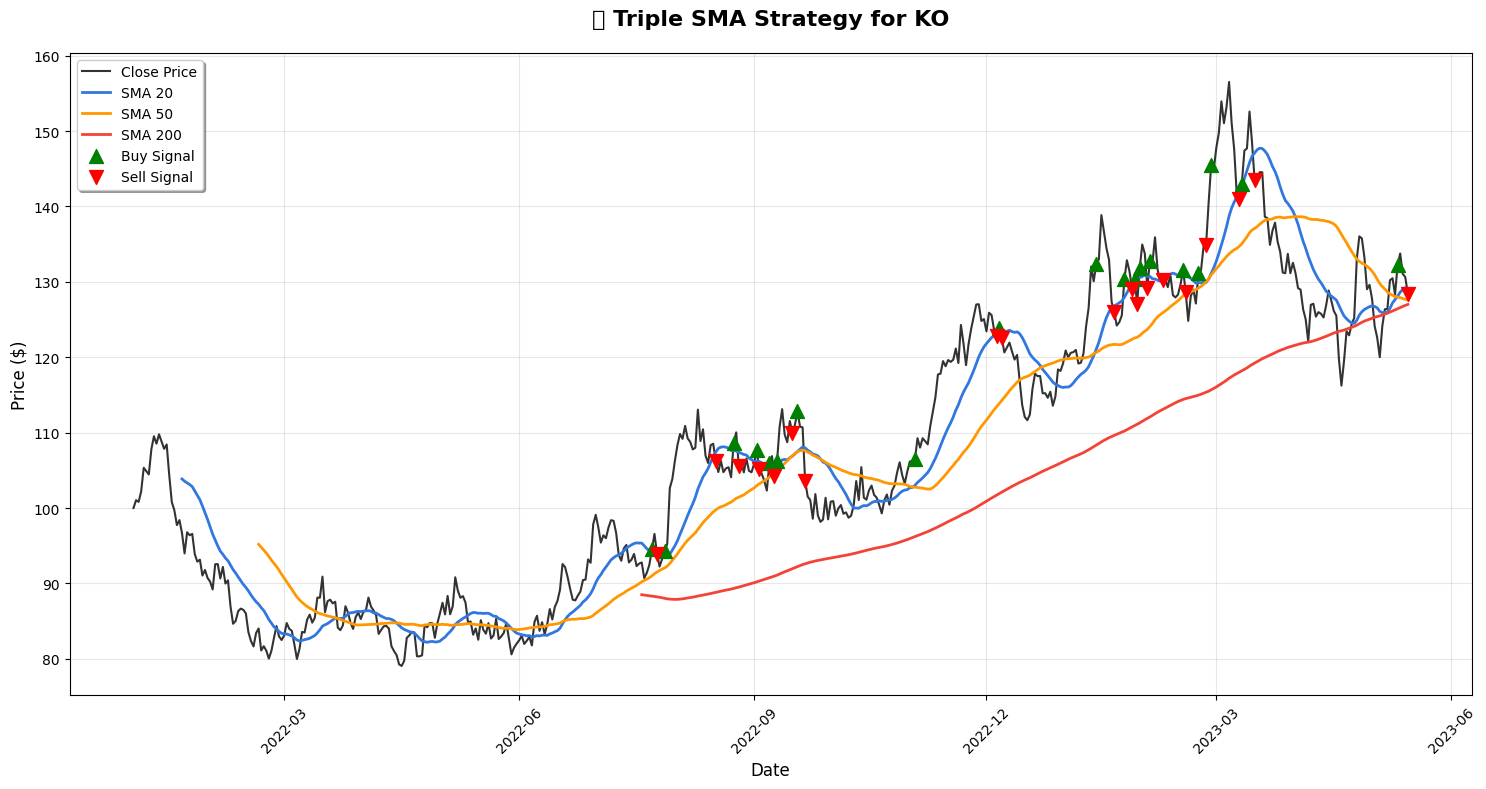


🔍 === Generating QuantStats Reports ===

📊 Basic Performance Metrics:
📈 CAGR: -2.43%
⚡ Sharpe Ratio: -0.06
📉 Max Drawdown: -20.13%
🎯 Win Rate: 49.11%
📊 Volatility (Ann.): 16.87%

📊 Plotting Cumulative Returns...


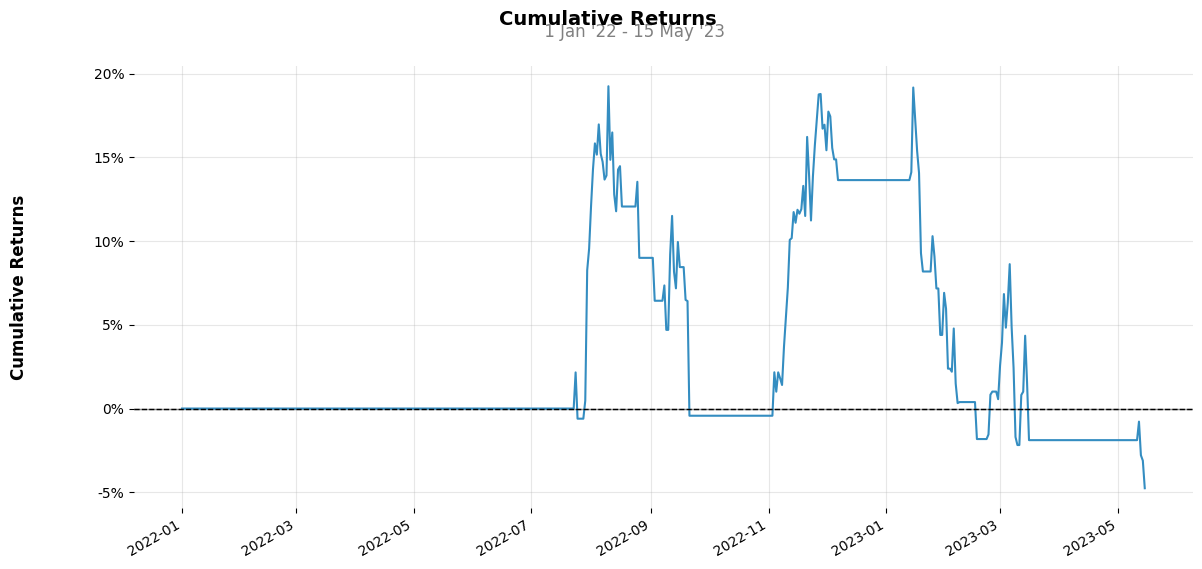

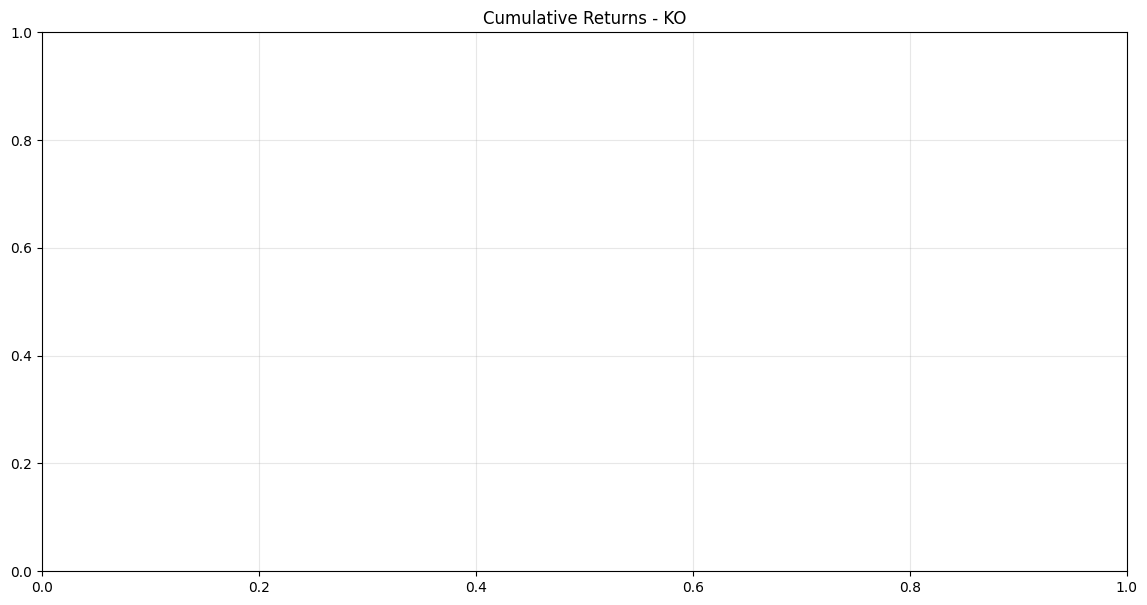


📉 Plotting Drawdowns...


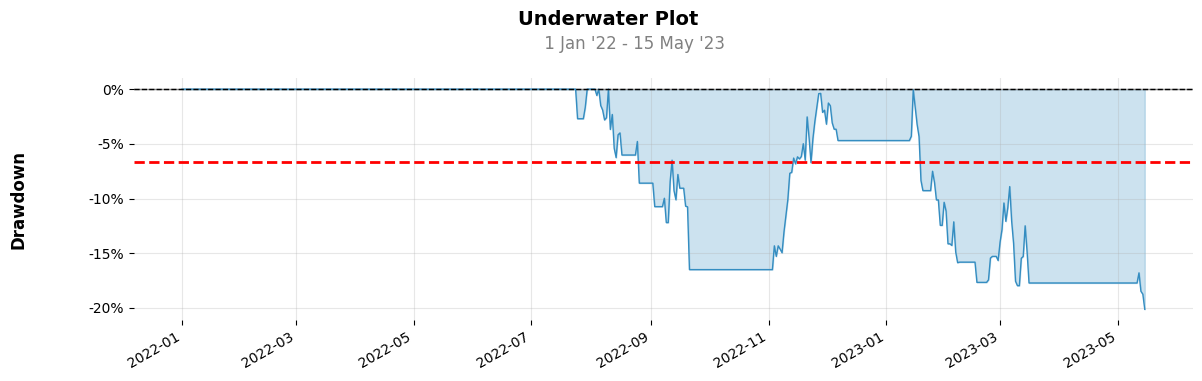

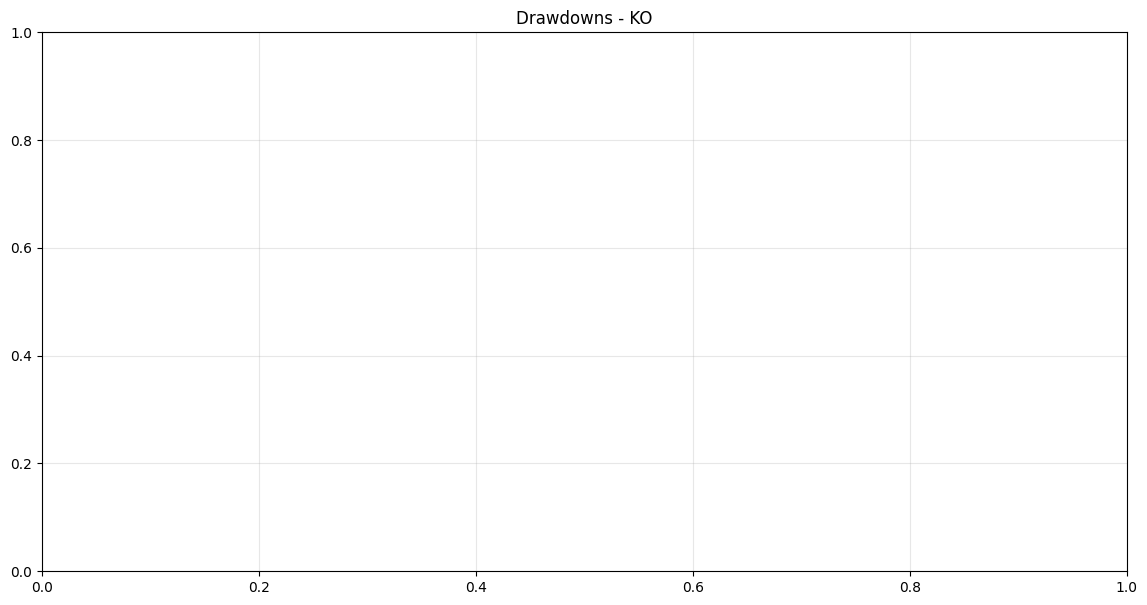


🔥 Plotting Monthly Returns Heatmap...


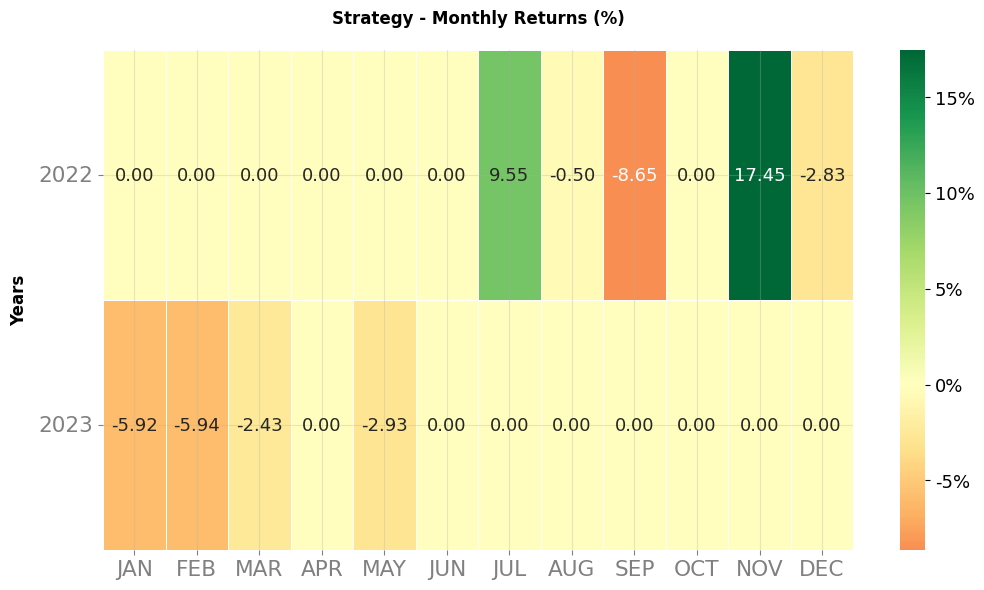

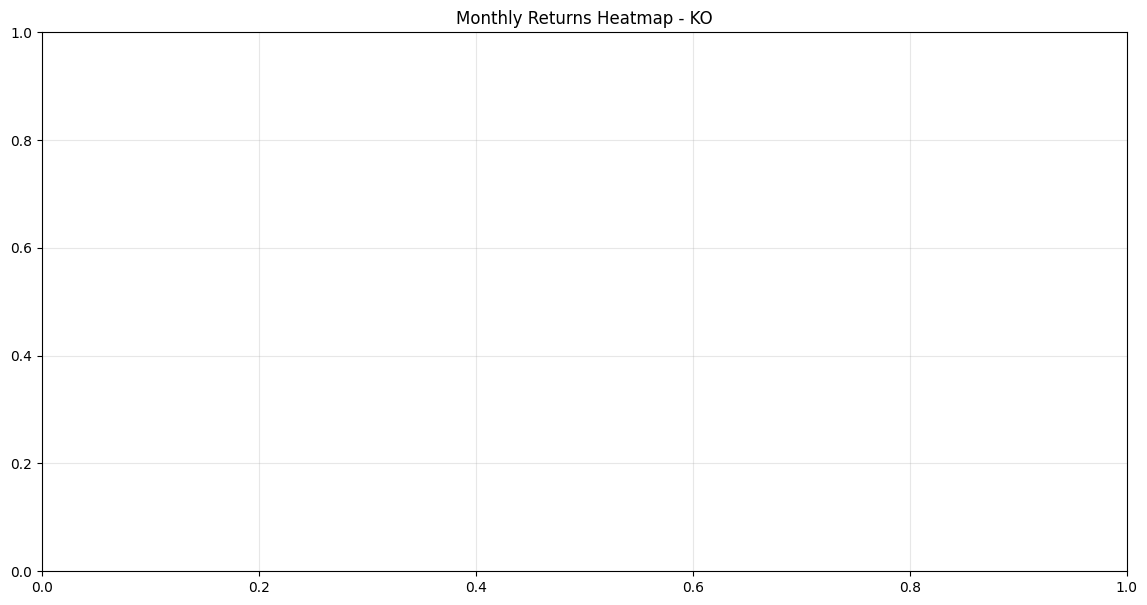


📋 Detailed Metrics:
                      Strategy
Start Period        2022-01-01
End Period          2023-05-15
Risk-Free Rate               0
Time in Market            0.23
Cumulative Return        -0.05
CAGR﹪                    -0.02
Sharpe                   -0.06
Prob. Sharpe Ratio        0.47
Sortino                  -0.09
Sortino/√2               -0.06
Omega                     0.98
Max Drawdown              -0.2
Longest DD Days            278
Gain/Pain Ratio          -0.02
Gain/Pain (1M)           -0.07
Payoff Ratio              1.02
Profit Factor             0.98
Common Sense Ratio        0.96
CPC Index                 0.49
Tail Ratio                0.98
Outlier Win Ratio        14.67
Outlier Loss Ratio        1.94
MTD                      -0.03
3M                       -0.05
6M                       -0.15
YTD                      -0.16
1Y                       -0.05
3Y (ann.)                -0.02
5Y (ann.)                -0.02
10Y (ann.)               -0.02
All-time (ann.)   

In [59]:
# Run the enhanced system with better connection handling
# run_triple_sma_system_enhanced()

# Uncomment the line below to run the system
run_triple_sma_system()